In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# WEATHER PREDICTION

Our dataset uses daily weather measurements from 18 different European cities for which daily observations were available in the years 2000 to 2010.

These were Basel (Switzerland), Budapest (Hungary), Dresden, Düsseldorf, Kassel, and Munich (all in Germany), De Bilt and Maastricht (Netherlands), Heathrow (UK), Ljubljana (Slovenia), Malmo and Stockholm (Sweden), Montélimar, Perpignan, and Tours (France), Oslo (Norway), Rome (Italy), and Sonnblick (Austria).

In [9]:
data = pd.read_csv("./weather_prediction_dataset.csv")
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


## CLEANING THE DATA

First we check if there is no missing data or set to null

In [10]:
missing_values = data.isnull().sum()
print("\nValori mancanti per colonna:")
print(missing_values)


Valori mancanti per colonna:
DATE                      0
MONTH                     0
BASEL_cloud_cover         0
BASEL_humidity            0
BASEL_pressure            0
                         ..
TOURS_global_radiation    0
TOURS_precipitation       0
TOURS_temp_mean           0
TOURS_temp_min            0
TOURS_temp_max            0
Length: 165, dtype: int64


And even if there are duplicate data rows

In [11]:
duplicate_values = data.duplicated().sum()
print("\nNumero di righe duplicate:", duplicate_values)


Numero di righe duplicate: 0


For our study, we decided to use data from only one of these cities in the dataset.
We chose Munich because it was the city with the most features in the dataset.

Therefore, we removed all columns related to the other cities and kept those related to Munich and those identifying day and month

In [12]:
columns_to_keep = ['DATE', 'MONTH'] + [col for col in data.columns if 'MUENCHEN' in col.upper()]
df = data[columns_to_keep]

data_copy = df.copy()


# Modify column names
for col in data_copy.columns[2:]:
    new_col_name = col.replace('MUENCHEN_', '')
    data_copy.rename(columns={col: new_col_name}, inplace=True)
df = data_copy

df['rainy_day'] = (df['precipitation'] > 0.05).astype(int)
df['sunny_day'] = (df['sunshine'] > 5).astype(int)
df['good_day'] = ((df['precipitation'] < 0.05) & (df['sunshine'] > 5) & (df['temp_mean'] > 14)).astype(int)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['year'] = df['DATE'].dt.year
df['day'] = df['DATE'].dt.day
df['MONTH'] = df['DATE'].dt.month

df.rename(columns={'MONTH': 'month'}, inplace=True)

df.drop('DATE', axis=1, inplace=True)

df = df[['day','month','year'] + [col for col in df.columns if col not in ['year', 'month', 'day']]]

df.head()

,day,month,year,cloud_cover,wind_speed,wind_gust,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max,rainy_day,sunny_day,good_day
0,1,1,2000,8,2.6,9.4,0.91,1.0273,0.20,0.20,0.0,1.7,-0.5,2.6,1,0,0
1,2,1,2000,6,2.1,8.2,0.90,1.0321,0.66,0.00,6.1,1.9,-0.2,5.8,0,1,0
2,3,1,2000,7,2.1,6.9,0.92,1.0317,0.28,0.00,0.4,-0.4,-3.3,0.9,0,0,0
3,4,1,2000,6,2.7,11.7,0.75,1.0260,0.58,0.04,4.5,3.8,-2.8,6.6,0,0,0
4,5,1,2000,5,3.3,13.2,0.87,1.0248,0.26,0.00,0.2,5.3,4.3,7.3,0,0,0


Once we have established that the data are in a correct form, we can move on to study them

## DATA ANALYSIS

The purpose of the project is to predict based on different features in the dataset whether it will rain or not

In [13]:
print("rows and columns:" + str(df.shape))
print("columns: " + str(df.columns))

rows and columns:(3653, 17)
columns: Index(['day', 'month', 'year', 'cloud_cover', 'wind_speed', 'wind_gust',
       'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine',
       'temp_mean', 'temp_min', 'temp_max', 'rainy_day', 'sunny_day',
       'good_day'],
      dtype='object')


Here is a brief explanation of the different columns in the dataset

| Feature (type)   | Column name 		| Description 		| Physical Unit 	|
|------------------|----------------------|-----------------------|-----------------|
| mean temperature | temp_mean  		| mean daily temperature| in 1 &#176;C  	|
| max temperature  | temp_max   		| max daily temperature | in 1 &#176;C  	|
| min temperature  | temp_min   		| min daily temperature | in 1 &#176;C  	|
| cloud_cover      | cloud_cover		| cloud cover           | oktas  		|
| global_radiation | global_radiation 	| global radiation      | in 100 W/m2  	|
| humidity         | humidity   		| humidity              | in 1 %  		|
| pressure         | pressure   		| pressure              | in 1000 hPa  	|
| precipitation    | precipitation 	| daily precipitation 	| in 10 mm  	|
| sunshine    	   | sunshine 		| sunshine hours  	| in 0.1 hours 	|
| wind_gust       | wind_gust  		| wind gust    		| in 1 m/s 		|
| wind_speed        | wind_speed 		| wind speed   		| in 1 m/s 		|


In [14]:
df.describe().style.background_gradient()

,day,month,year,cloud_cover,wind_speed,wind_gust,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max,rainy_day,sunny_day,good_day
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,15.731454,6.522310,2004.499589,5.225568,2.792581,9.769559,0.741900,1.017457,1.426764,0.261653,5.221243,10.053490,5.998741,14.542924,0.397482,0.466192,0.188886
std,8.802064,3.449345,2.873056,2.318678,1.315460,4.291747,0.132921,0.008218,0.983868,0.599693,4.594628,7.903456,7.056216,9.170031,0.489444,0.498924,0.391472
min,1.000000,1.000000,2000.000000,0.000000,0.700000,2.600000,0.200000,0.984000,0.190000,0.000000,0.000000,-12.900000,-16.400000,-9.900000,0.000000,0.000000,0.000000
25%,8.000000,4.000000,2002.000000,4.000000,1.900000,6.600000,0.650000,1.012600,0.580000,0.000000,0.700000,3.900000,0.600000,7.300000,0.000000,0.000000,0.000000
50%,16.000000,7.000000,2004.000000,6.000000,2.500000,8.700000,0.750000,1.017200,1.150000,0.010000,4.400000,10.400000,6.300000,14.800000,0.000000,0.000000,0.000000
75%,23.000000,10.000000,2007.000000,7.000000,3.300000,11.900000,0.840000,1.022500,2.230000,0.280000,8.900000,16.300000,11.700000,21.900000,1.000000,1.000000,0.000000
max,31.000000,12.000000,2009.000000,8.000000,10.400000,30.900000,1.000000,1.044000,3.650000,9.790000,15.700000,29.200000,22.000000,37.000000,1.000000,1.000000,1.000000


Now we study the correlation to see which features affect other

<Axes: >

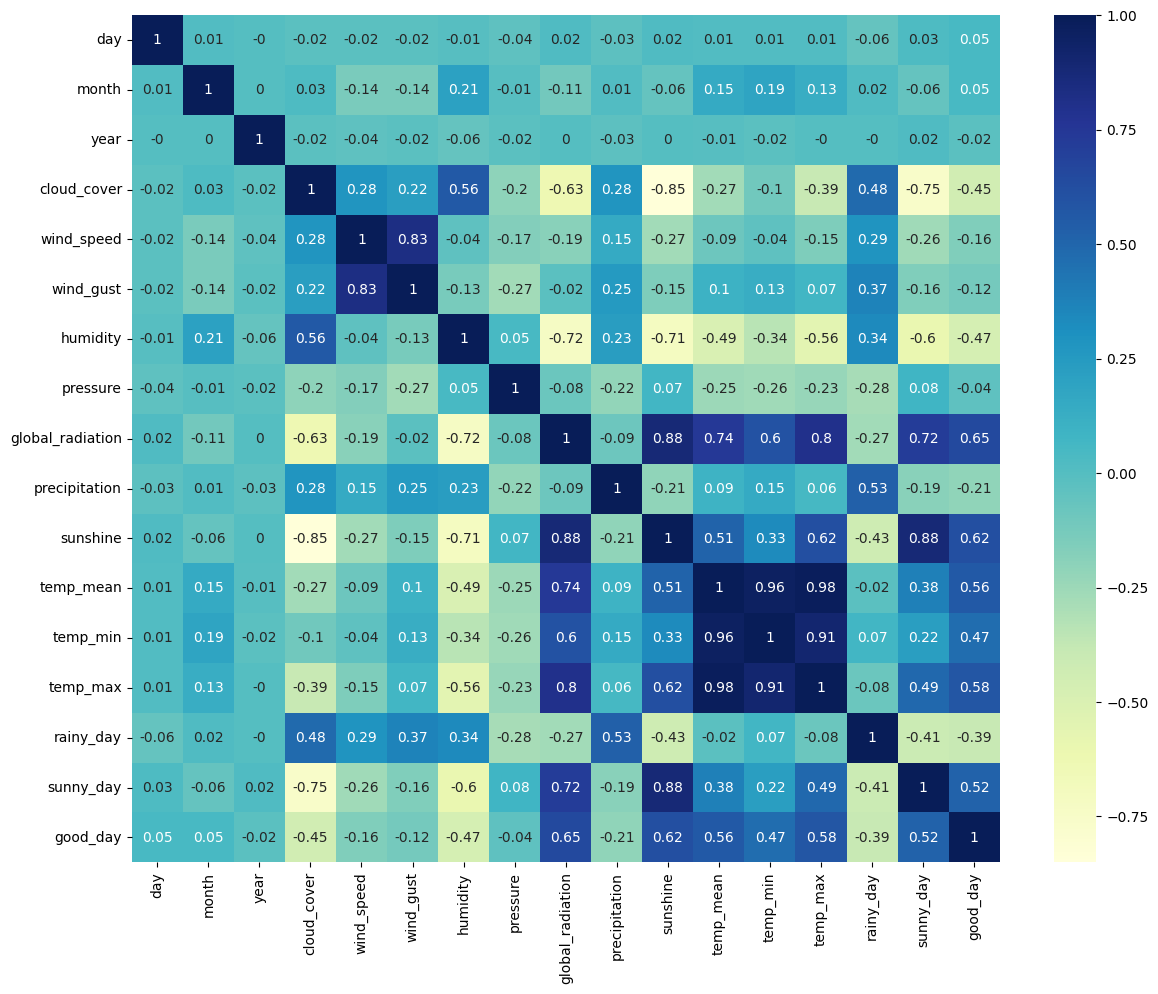

In [15]:
df.corr().style.background_gradient(cmap="Blues")
corr_matrix = np.round(df.corr(), 2)
plt.figure(figsize=(14,11))
sns.heatmap(
    corr_matrix,
    cmap="YlGnBu",
    annot=True,
)

From the correlation study we can see how some features in the dataset are in close contact with each other.
For example:
- Cloud cover with humidity and with precipitation and wind speed
- As cloud cover increases, sunshine and global radiation clearly decrease
- Humidity and precipitation
- as humidity increases, sunshine, global radiation and maximum temperatures decrease
- sunshine and global radiation are highly correlated
- temperatures depend on many different features

we can also say that the rainy_day condition depends on many different factors among which the ones that stand out the most: cloud_cover, wind_speed and gust, humidity and precipitation and in negative pressure, sunshine and global_radiation.
As might be expected, the feature that most affects the chance of a rainy day is precipitation

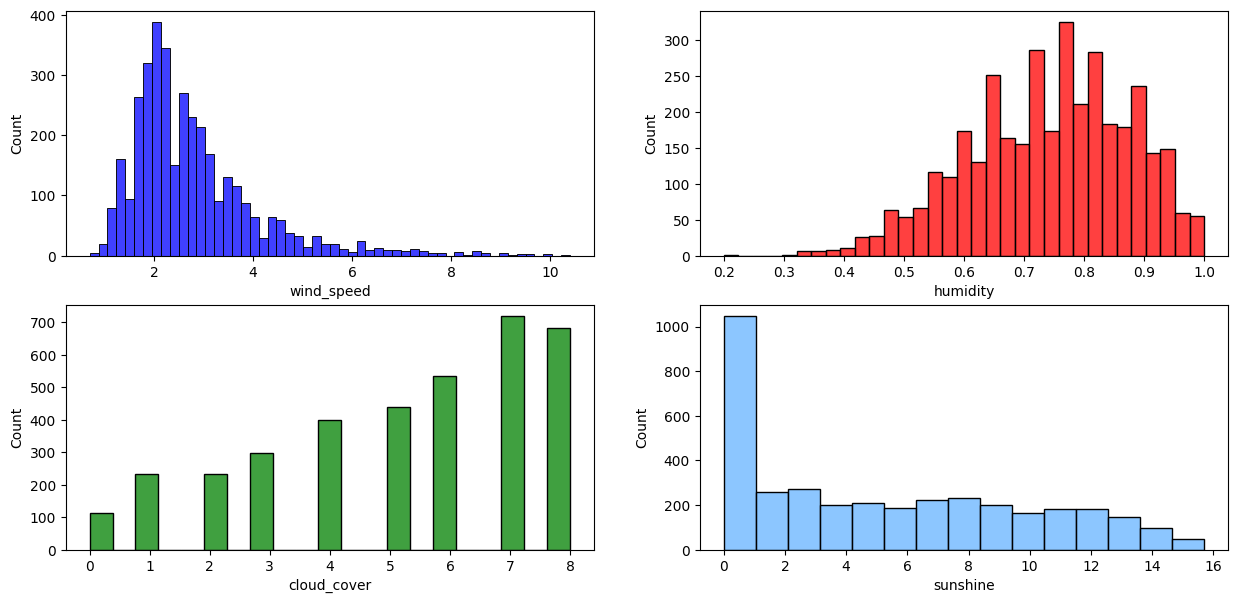

In [16]:
fig, axs = plt.subplots(2,2, figsize=(15,7))
axs = axs.flatten()
sns.histplot(df['wind_speed'],color='blue',ax=axs[0])
sns.histplot(df['humidity'],color='red',ax=axs[1])
sns.histplot(df['cloud_cover'],color='green',ax=axs[2])
sns.histplot(df['sunshine'],color='#66b3ff',ax=axs[3])
plt.show()

HOW DO PRECIPITATION AND TEMPERATURES VARY OVER TIME?

as we can see, both precipitation and temperatures have a fairly constant pattern over the years with an increase in them during the summer months 

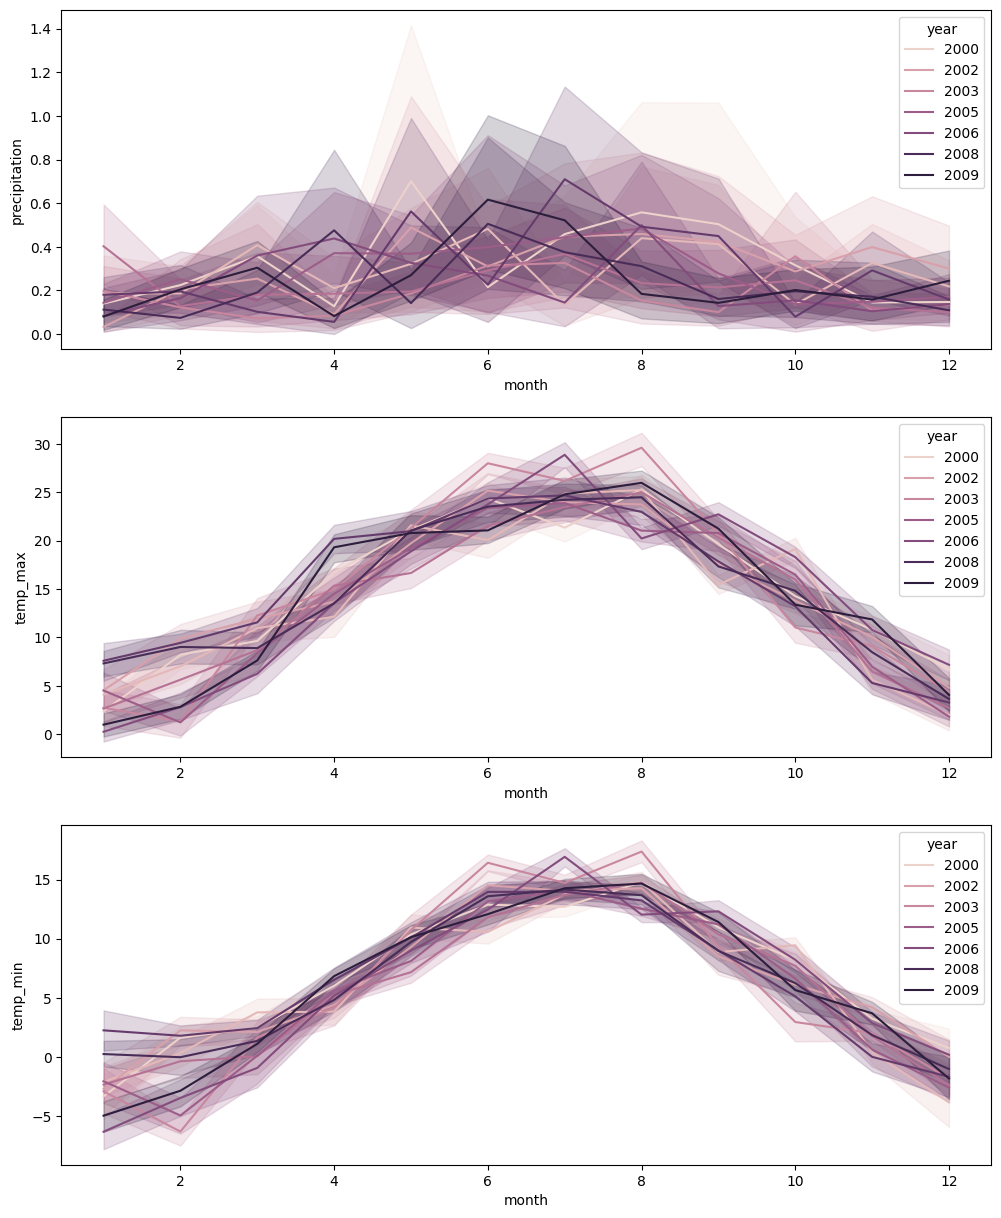

In [17]:
# plotto i valori delle precipitazione per ogni anno in base ai mesi

fig, axs = plt.subplots(3,1, figsize=(12,15))
axs = axs.flatten()
sns.lineplot(data=df, x='month', y='precipitation', hue='year',ax=axs[0])
sns.lineplot(data=df, x='month', y='temp_max', hue='year', ax=axs[1])
sns.lineplot(data=df, x='month', y='temp_min', hue='year', ax=axs[2])
plt.show()



HOW DOES SUNSHINE VARY OVER TIME?


as imaginable sunshine increases significantly in the summer months compared to the winter months where there are fewer hours of sunshine

/tmp/ipykernel_20699/3391362982.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='month', y='sunshine', errorbar=None, palette='viridis')


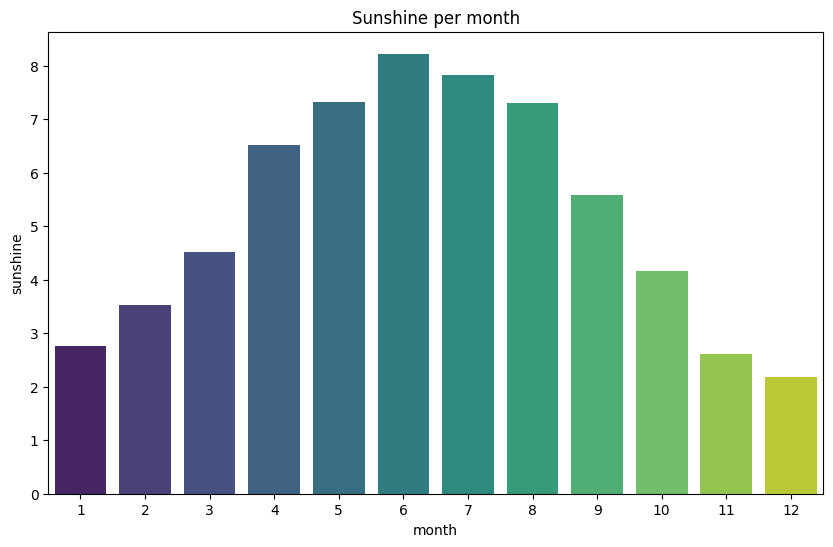

In [18]:
# grafico sui sunshine per ogni mese
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='month', y='sunshine', errorbar=None, palette='viridis')
plt.title('Sunshine per month')
plt.show()


STUDY OF CONDITIONS FOR A RAINY DAY

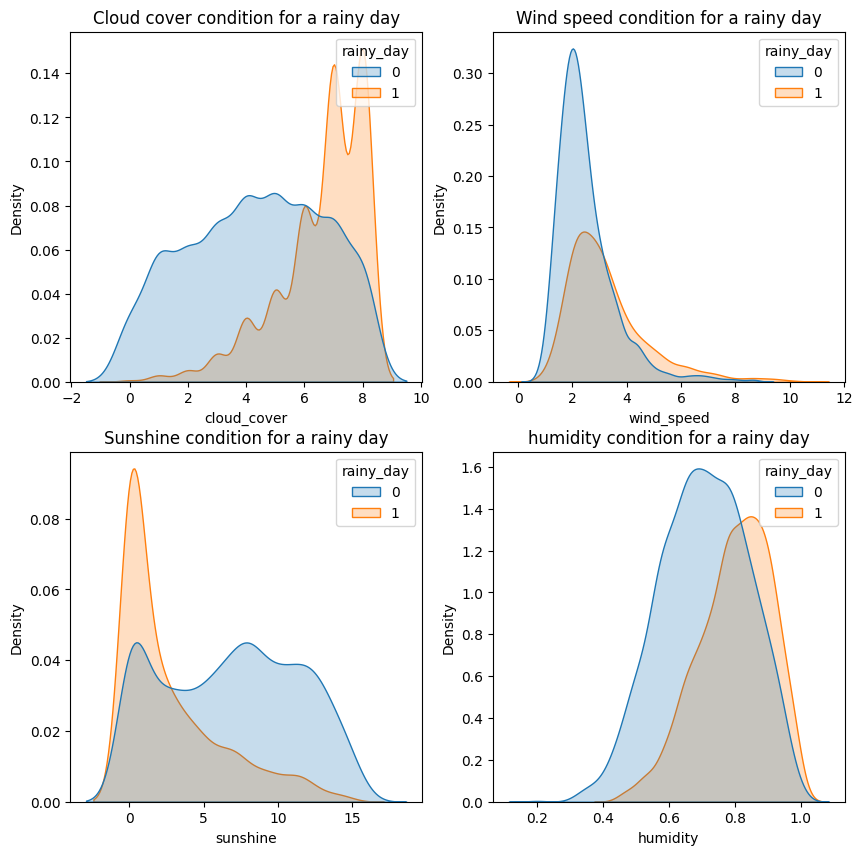

In [19]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.kdeplot(data = df, x='cloud_cover', hue = 'rainy_day', fill = True, ax = axs[0,0])
axs[0,0].set_title('Cloud cover condition for a rainy day')
sns.kdeplot(data = df, x='wind_speed', hue = 'rainy_day', fill = True, ax = axs[0,1])
axs[0,1].set_title('Wind speed condition for a rainy day')
sns.kdeplot(data = df, x='sunshine', hue = 'rainy_day', fill = True, ax = axs[1,0])
axs[1,0].set_title('Sunshine condition for a rainy day')
sns.kdeplot(data = df, x='humidity', hue = 'rainy_day', fill = True, ax = axs[1,1])
axs[1,1].set_title('humidity condition for a rainy day')

plt.show()

these graphs can confirm the correlation there is between the different features in the dataset.


It can be clearly seen that greater cloud cover leads to more probability that it will be a rainy day.


It can also be said that wind leads to a decrease in the probability of rain as does sunshine.


In contrast, the humidity graph makes it clear that humidity does not affect the probability of a rainy day very much

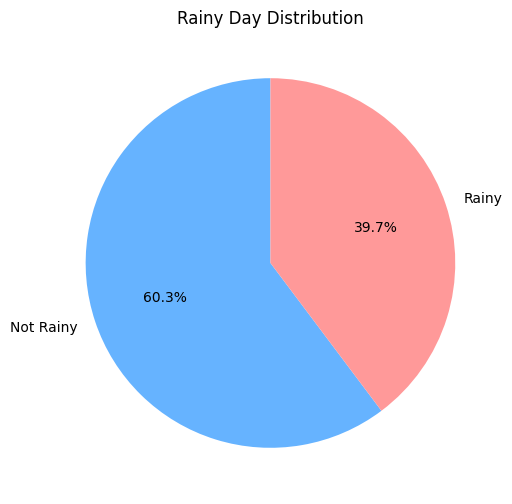

In [20]:
# grafico a barre per vedere la distribuzione dei gioni piovosi e non piovosi
plt.figure(figsize=(10,6))
plt.pie(df['rainy_day'].value_counts(), labels=['Not Rainy', 'Rainy'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Rainy Day Distribution')
plt.show()


In general, the distribution of rainy and non-rainy days is quite balanced although it seems that those where it does not rain are more

DOES TEMPERATURE AFFECT RAINFALL?

It would seem not even though on days without rain the temperatures are slightly higher

/tmp/ipykernel_20699/1830856760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='rainy_day', y='temp_mean', palette='viridis')


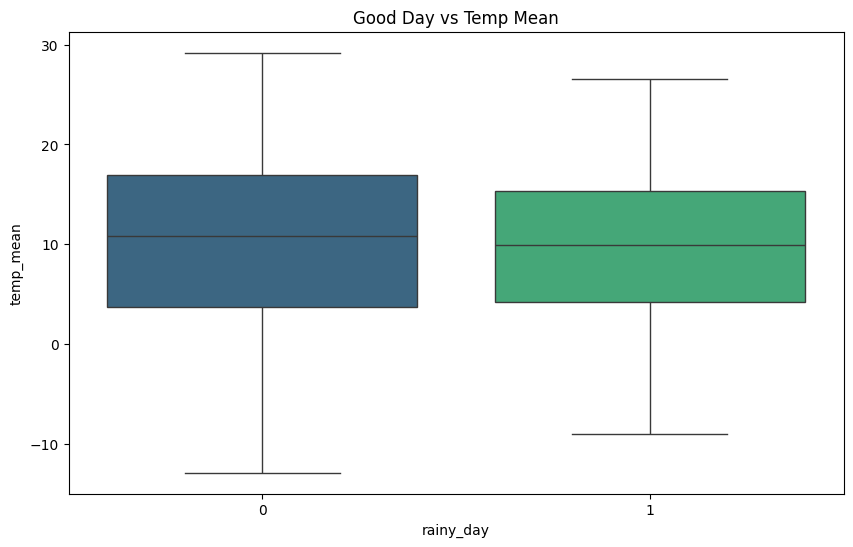

In [21]:
#fai un grafico boxplot con sulle y la temperatura media e sulle x i good_day
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='rainy_day', y='temp_mean', palette='viridis')
plt.title('Good Day vs Temp Mean')
plt.show()



## MACHINE LEARNING


In [22]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    recall_score
)

In [23]:
y = df["rainy_day"]
x = df.drop(columns=["rainy_day","precipitation","good_day","sunny_day"])

In [24]:
rus = RandomUnderSampler(random_state=42)
#x_rus, y_rus = rus.fit_resample(x, y)
x_rus, y_rus = x , y

i dati sembrano bilanciati correttamente, non c'è bisogno di fare un sample del dataset

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


scaler = MinMaxScaler()
norm_X = scaler.fit_transform(x_rus,y_rus)
norm_X = pd.DataFrame(norm_X, columns = x_rus.columns)
norm_X.head()

,day,month,year,cloud_cover,wind_speed,wind_gust,humidity,pressure,global_radiation,sunshine,temp_mean,temp_min,temp_max
0,0.000000,0.0,0.0,1.000,0.195876,0.240283,0.8875,0.721667,0.002890,0.000000,0.346793,0.414062,0.266525
1,0.033333,0.0,0.0,0.750,0.144330,0.197880,0.8750,0.801667,0.135838,0.388535,0.351544,0.421875,0.334755
2,0.066667,0.0,0.0,0.875,0.144330,0.151943,0.9000,0.795000,0.026012,0.025478,0.296912,0.341146,0.230277
3,0.100000,0.0,0.0,0.750,0.206186,0.321555,0.6875,0.700000,0.112717,0.286624,0.396675,0.354167,0.351812
4,0.133333,0.0,0.0,0.625,0.268041,0.374558,0.8375,0.680000,0.020231,0.012739,0.432304,0.539062,0.366738


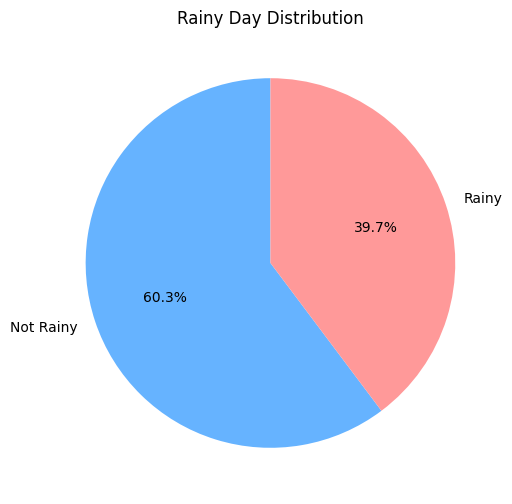

In [26]:
# grafico a barre per vedere la distribuzione dei gioni piovosi e non piovosi
plt.figure(figsize=(10,6))
plt.pie(y_rus.value_counts(), labels=['Not Rainy', 'Rainy'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Rainy Day Distribution')
plt.show()


In [27]:

# Splitting dataset on training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(norm_X,y_rus, test_size = 0.3, random_state = 42)
print('Training set: ' + str(len(X_train)))
print('Testing set: ' + str(len(X_test)))

Training set: 2557
Testing set: 1096


In [38]:
def report(y_test, y_pred):
    print("Results of test set prediction analyzing:\n")

    print(f"Accuracy of prediction: {np.round(accuracy_score(y_test, y_pred) * 100,2)}%")
    print(f"roc-auc score: {np.round(roc_auc_score(y_test, y_pred)*100,2)}%")
    print(f"f1 score: {np.round(f1_score(y_test, y_pred)*100,2)}%")
    print(f"recall score: {np.round(recall_score(y_test, y_pred)*100,2)}%")
    
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='g').set(title='Confusion Matrix')



## SVC

### Training

In [29]:
from sklearn.svm import SVC

model = SVC(verbose=True, kernel = 'linear', random_state = 0)
_ = model.fit(X_train,y_train)


[LibSVM].
*
optimization finished, #iter = 1627
obj = -1244.512752, rho = -4.716187
nSV = 1280, nBSV = 1268
Total nSV = 1280


In [30]:
y_predict = model.predict(X_test)

### Metrics

Results of test set prediction analyzing:

Accuracy of prediction: 80.38%
roc-auc score: 79.2%
f1 score: 75.09%
recall score: 72.97%


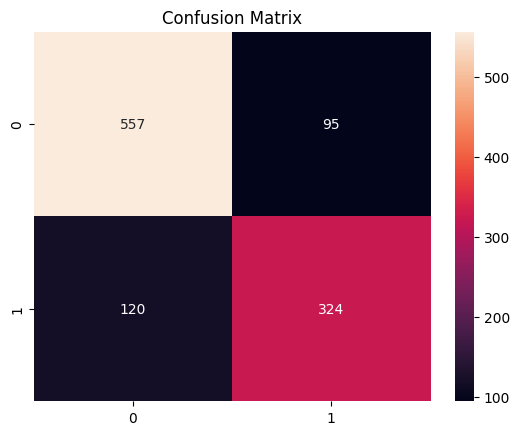

In [39]:
report(y_test, y_predict)

### Tuning

In [40]:
#tuning the model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']
              }
grid = GridSearchCV(SVC(),param_grid,refit=True,n_jobs = -1,verbose=2,cv=10, scoring='accuracy')
grid.fit(X_train,y_train)



Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

{'C': 1, 'gamma': 1, 'kernel': 'poly'}
SVC(C=1, gamma=1, kernel='poly')
Results of test set prediction analyzing:

Accuracy of prediction: 79.84%
roc-auc score: 78.35%
f1 score: 73.91%
recall score: 70.5%


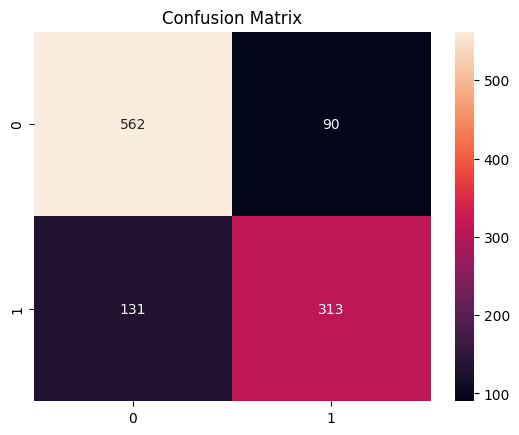

In [41]:
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
report(y_test, grid_predictions)

## LOGISTIC REGRESSION

### Model

In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
_ = model.fit(X_train, y_train)


In [45]:
y_predict = model.predict(X_test)

Results of test set prediction analyzing:

Accuracy of prediction: 80.38%
roc-auc score: 79.2%
f1 score: 75.09%
recall score: 72.97%


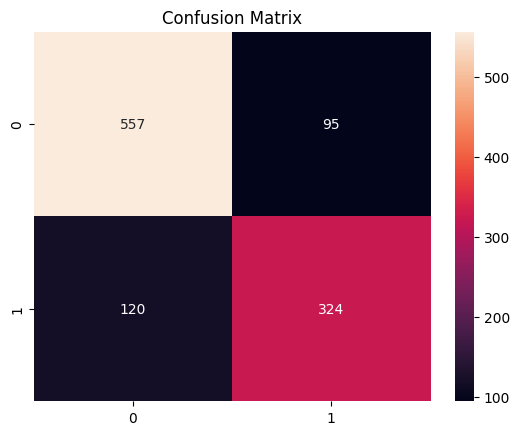

In [46]:
report(y_test, y_predict)

### Tuning

In [ ]:
# tuning the model
param_grid = {'C': np.logspace(-3, 3, 7),
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']
              }
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,n_jobs = -1,verbose=2,cv=10, scoring='accuracy')
grid.fit(X_train,y_train)


{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(penalty='l1', solver='liblinear')
Results of test set prediction analyzing:

Accuracy of prediction: 80.38%
roc-auc score: 79.38%
f1 score: 75.37%
recall score: 74.1%


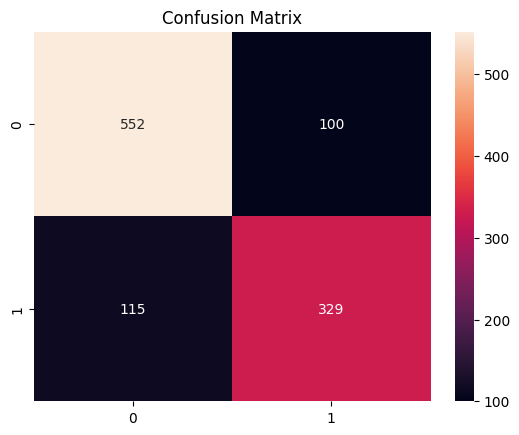

In [50]:
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
report(y_test, grid_predictions)

## KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
_ = model.fit(X_train, y_train)

In [60]:
y_predict = model.predict(X_test)

### Metrics

Results of test set prediction analyzing:

Accuracy of prediction: 76.92%
roc-auc score: 75.75%
f1 score: 70.95%
recall score: 69.59%


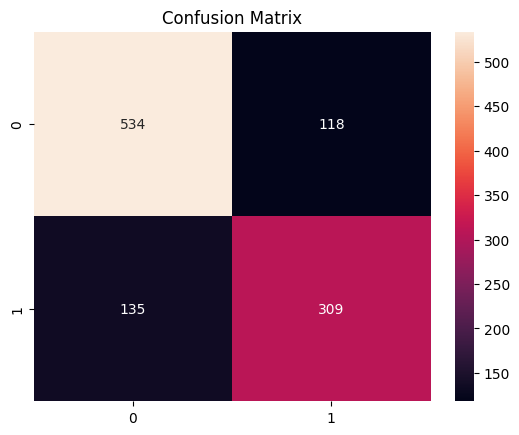

In [61]:
report(y_test, y_predict)

### Tuning

In [64]:
# tuning the model
param_grid = {'n_neighbors': np.arange(10,25),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
              }
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,n_jobs = -1,verbose=2,cv=10, scoring='accuracy')
grid.fit(X_train,y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, we

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')
Results of test set prediction analyzing:

Accuracy of prediction: 77.28%
roc-auc score: 76.38%
f1 score: 71.86%
recall score: 71.62%


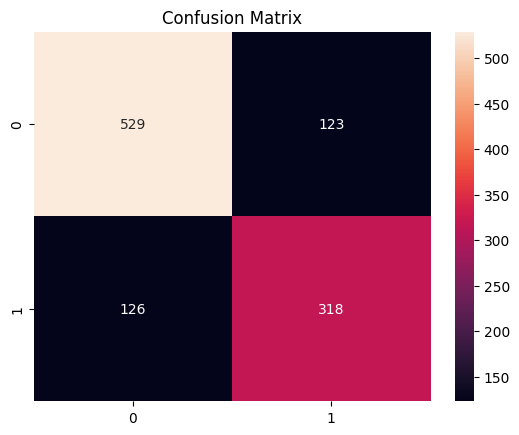

In [65]:
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
report(y_test, grid_predictions)

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
_ = model.fit(X_train, y_train)

In [53]:
y_predict = model.predict(X_test)

### Metrics

Results of test set prediction analyzing:

Accuracy of prediction: 79.74%
roc-auc score: 78.45%
f1 score: 74.13%
recall score: 71.62%


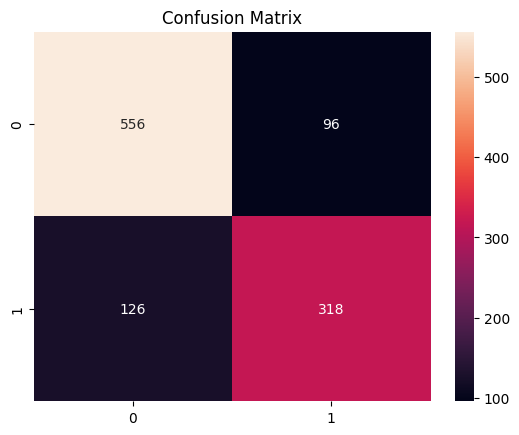

In [54]:
report(y_test, y_predict)

### Tuning

In [56]:
# tuning the model
param_grid = {'n_estimators': [100, 200, 300],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [10, 30, 60],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]
              }
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,n_jobs = -1,verbose=2,cv=10, scoring='accuracy')
grid.fit(X_train,y_train)


Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; to

/home/f4de/miniconda3/envs/mlda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
230 fits failed with the following error:
Traceback (most recent call last):
  File "/home/f4de/miniconda3/envs/mlda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/f4de/miniconda3/envs/mlda/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/f4de/miniconda3/envs/mlda/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    valida

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 30, 60],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

{'bootstrap': False, 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(bootstrap=False, max_depth=60, max_features='log2',
                       min_samples_leaf=2)
Results of test set prediction analyzing:

Accuracy of prediction: 79.84%
roc-auc score: 78.53%
f1 score: 74.21%
recall score: 71.62%


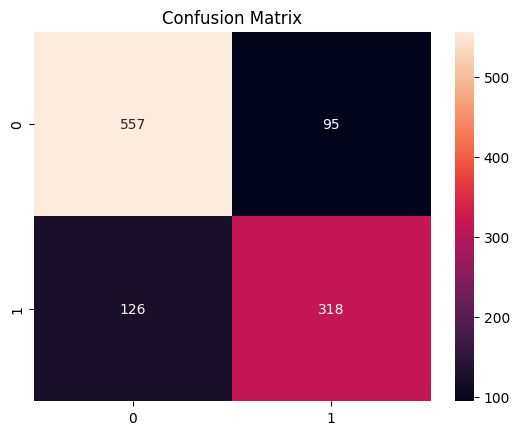

In [57]:
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
report(y_test, grid_predictions)